In [3]:
import os
import rasterio
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
from rasterio.plot import show


#### 1. data check

In [4]:
dir_save = 'data/dianchi_test/raster'
path_dianchi_vec = 'data/dianchi_test/dianchi_vector.gpkg'


In [11]:
## Check original .nc raster file.
paths_file = [os.path.join(dir_save, file) for file in os.listdir(dir_save) if 'Raster_100m_' in file and '.nc' in file]
print(paths_file[5])
raster_nc = xr.open_dataset(paths_file[0])
raster_nc


data/dianchi_test/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_011_049_099F_20240216T144649_20240216T144710_PIC0_01.nc


<xarray.Dataset>
Dimensions:                  (x: 1501, y: 1500)
Coordinates:
  * x                        (x) float64 1.961e+05 1.962e+05 ... 3.461e+05
  * y                        (y) float64 2.645e+06 2.645e+06 ... 2.795e+06
Data variables: (12/39)
    crs                      object ...
    longitude                (y, x) float64 ...
    latitude                 (y, x) float64 ...
    wse                      (y, x) float32 ...
    wse_qual                 (y, x) float32 ...
    wse_qual_bitwise         (y, x) float64 ...
    ...                       ...
    load_tide_fes            (y, x) float32 ...
    load_tide_got            (y, x) float32 ...
    pole_tide                (y, x) float32 ...
    model_dry_tropo_cor      (y, x) float32 ...
    model_wet_tropo_cor      (y, x) float32 ...
    iono_cor_gim_ka          (y, x) float32 ...
Attributes: (12/49)
    Conventions:                   CF-1.7
    title:                         Level 2 KaRIn High Rate Raster Data Product
    source:                        Ka-band radar interferometer
    history:                       2024-06-03T10:20:45Z : Creation
    platform:                      SWOT
    references:                    V1.2.1
    ...                            ...
    x_min:                         196100.0
    x_max:                         346100.0
    y_min:                         2644900.0
    y_max:                         2794800.0
    institution:                   CNES
    product_version:               01

In [12]:
date_data = [path.split('_')[-4][0:8] for path in paths_file]
date_data = [date[0:4]+'-'+date[4:6]+'-'+date[6:8] for date in date_data]
print(date_data)


['2024-05-30', '2024-01-05', '2024-01-26', '2024-05-10', '2024-04-19', '2024-02-16', '2024-06-20', '2024-03-08', '2024-03-29']


#### 2. data preprocessing
2.1 convert .nc file to .tif file.   
2.2 reproject utm48 to wgs84 projection.   
2.3 layer stacking for .tif files


In [13]:
nc_var = 'wse_qual'
paths_file_tif = [path.replace('.nc', '_'+ nc_var +'.tif') for path in paths_file]
paths_file_wgs84 = [path.replace('.tif', '_wgs84.tif') for path in paths_file_tif]
print(paths_file[0])
print(paths_file_tif[0])
print(paths_file_wgs84[0])


data/dianchi_test/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_016_049_099F_20240530T223211_20240530T223232_PIC0_01.nc
data/dianchi_test/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_016_049_099F_20240530T223211_20240530T223232_PIC0_01_wse_qual.tif
data/dianchi_test/raster/SWOT_L2_HR_Raster_100m_UTM48R_N_x_x_x_016_049_099F_20240530T223211_20240530T223232_PIC0_01_wse_qual_wgs84.tif


In [13]:
# for i, _ in enumerate(paths_file):
#   path_nc, path_tif, path_tif_wgs84 = paths_file[i], paths_file_tif[i], paths_file_wgs84[i]
#   !gdalmdimtranslate \
#       -of "GTiff" \
#       -array $nc_var \
#       -co "COMPRESS=LZW" $path_nc $path_tif

#   !gdalwarp -overwrite \
#       -s_srs EPSG:32648 \
#       -t_srs EPSG:4326 \
#       -r cubic \
#       -co COMPRESS=LZW \
#       -co TILED=YES \
#       $path_tif $path_tif_wgs84


In [14]:
# path_laysta = dir_save+'/dianchi_'+ nc_var +'_wgs84_laysta.tif'
# _ = lay_stack(path_imgs=paths_file_wgs84, path_out=path_laysta, union=True, res=None)


#### 3. data reading and visualization.

In [14]:
dianchi_gpd = gpd.read_file(path_dianchi_vec)
dianchi_gpd


,Name,geometry
0,dianchi,"POLYGON Z ((102.68034 24.83585 0.00000, 102.65..."


<Axes: >

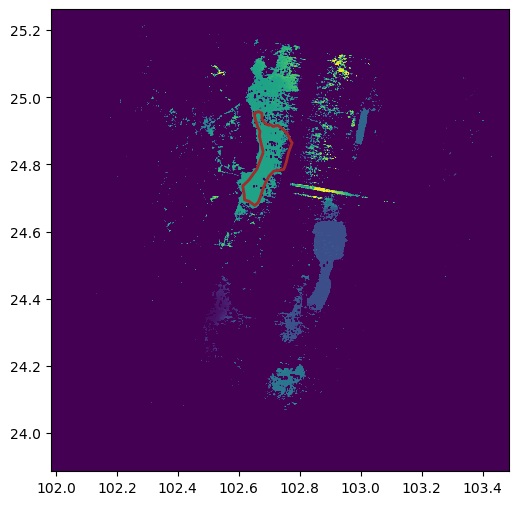

In [17]:
path_laysta_wse = dir_save+'/dianchi_wse_wgs84_laysta.tif'
path_laysta_wse_qual = dir_save+'/dianchi_wse_qual_wgs84_laysta.tif'
src_wse = rasterio.open(path_laysta_wse)
src_wse_qual = rasterio.open(path_laysta_wse_qual)
raster_wse = src_wse.read(6)
fig, ax = plt.subplots(1, figsize=(6,6))
show(raster_wse, ax=ax, vmax=2100, vmin=1600, transform=src_wse.transform)
dianchi_gpd.plot(ax=ax, edgecolor='Brown', facecolor='none', linewidth=2)



In [63]:
wse, wse_transform = mask(
    src_wse, 
    dianchi_gpd['geometry'].to_list(), 
    crop=True, 
    nodata=np.nan
)
wse_qual, wse_qual_transform = mask(
    src_wse_qual, 
    dianchi_gpd['geometry'].to_list(), 
    crop=True, 
    nodata=np.nan
)
print(wse.shape)
print(wse_qual.shape)


(9, 297, 172)
(9, 297, 172)


<Axes: >

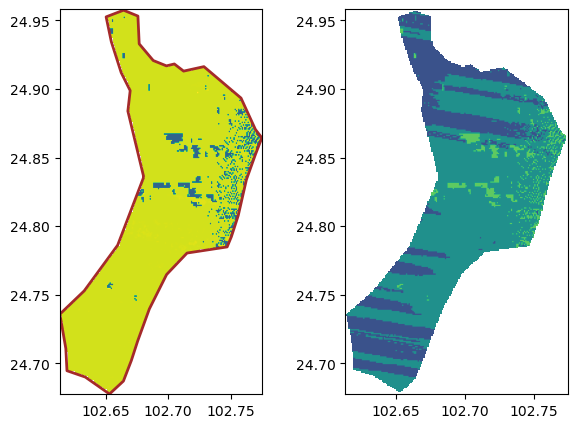

In [64]:
### check the wse and wse_qual image.
id = 1
fig, ax = plt.subplots(1, 2, figsize=(7, 5))
show(wse[id], transform=wse_transform, vmax=2100, vmin=-1000, ax=ax[0])
show(wse_qual[id], transform=wse_qual_transform, vmin=0, vmax=4, ax=ax[1])
dianchi_gpd.plot(ax=ax[0], edgecolor='Brown', facecolor='none', linewidth=2)


#### 4. mask out the low quality measurments.


Text(0.5, 1.0, 'wse_masked')

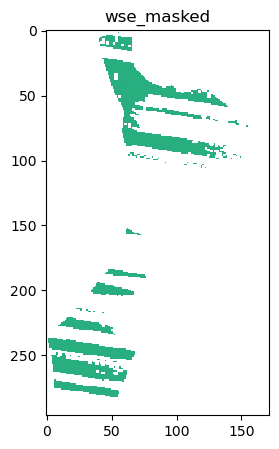

In [221]:
wse_masked = np.where((wse_qual<=1) & (wse_qual>=0), wse, np.nan)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.imshow(wse_masked[id,:,:], vmin=1700, vmax=2000)
ax.set_title('wse_masked')


In [166]:
wse_masked_mean = np.nanmean(wse_masked, axis=(1,2))
wse_masked_std = np.nanstd(wse_masked, axis=(1,2))
print(wse_masked_mean)
print(wse_masked_std)


[1888.0156 1888.0809 1888.4396 1887.7399 1887.9412 1888.1193 1888.2383
 1887.938  1887.9292]
[20.714643   6.110406   8.478878   4.9113793  6.457739   4.92209
  7.4468994  2.9185095  3.6811252]


In [90]:
wse_perc_10 = [np.nanpercentile(wse, 10) for wse in wse_masked]
wse_perc_90 = [np.nanpercentile(wse, 90) for wse in wse_masked]
print(wse_perc_10[0], wse_perc_90[0])


1887.256396484375 1887.7551025390626


In [91]:
wse_masked_2 = []
for band in range(wse_masked.shape[0]):
  wse_val = np.where((wse_masked[band]>=wse_perc_10[band]) & \
                          (wse_masked[band]<=wse_perc_90[band]), wse[band], np.nan)
  wse_masked_2.append(wse_val)
wse_masked_2 = np.stack(wse_masked_2, axis=0)


Text(0.5, 1.0, 'wse_masked_2')

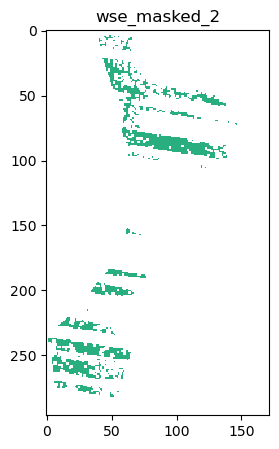

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.imshow(wse_masked_2[id,:,:], vmin=1700, vmax=2000)
ax.set_title('wse_masked_2')

In [167]:
wse_masked_2_mean = np.nanmean(wse_masked_2, axis=(1,2))
wse_masked_2_std = np.nanstd(wse_masked_2, axis=(1,2))
print(wse_masked_2_mean)
print(wse_masked_2_std)


[1887.4585 1887.6873 1887.7024 1887.4917 1887.5829 1887.8148 1887.6077
 1887.7295 1887.6747]
[0.10835818 0.06485174 0.07434777 0.07217024 0.06954192 0.07208102
 0.07598332 0.07867119 0.08400235]


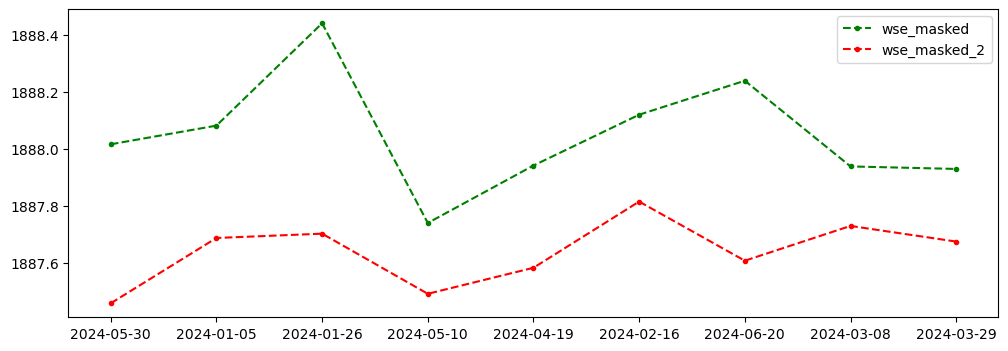

In [213]:
x = np.arange(len(wse_masked_mean))
fig = plt.figure(figsize=(12,4))
ax = plt.plot(date_data, wse_masked_mean, '--.', color='green', label='wse_masked')
plt.plot(date_data, wse_masked_2_mean, '--.', color='red', label='wse_masked_2')
plt.legend()

In [219]:
wse_masked_flatten = [wse_masked[id][~np.isnan(wse_masked[id])] for id in range(wse_masked.shape[0])]
wse_masked_2_flatten = [wse_masked_2[id][~np.isnan(wse_masked_2[id])] for id in range(wse_masked_2.shape[0])]
# wse_masked_2_flatten


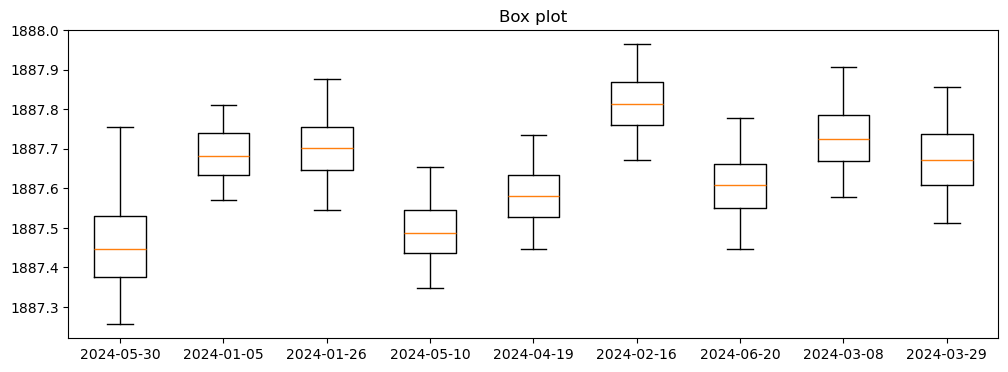

In [218]:
# plot violin plot
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.boxplot(wse_masked_2_flatten)
ax.set_title('Box plot')
ax.set_xticks(np.arange(len(date_data))+1, date_data);
